### Author: Sawandi Kirby  
### Date: 2026-01-28

# 📦 3PL Supply Chain Analysis  
## Shipment Pricing, Reliability, and Cost Tradeoffs

## Third-party logistics providers face a constant tradeoff:  
## **improve on-time delivery without driving transportation costs through the roof.**

## Using real-world shipment pricing and delivery data, this notebook analyzes how:

### - 🚚 **Shipment mode**
### - 🏭 **Vendor operations**
### - 🌍 **Geography**

### impact **on-time delivery performance**, **delivery timing**, and **logistics cost** — and where targeted 3PL interventions can deliver the biggest reliability gains per dollar spent.

---

## 🎯 Business Question

## **Where can a third-party logistics provider intervene to improve delivery reliability without disproportionately increasing transportation spend?**

## To answer this, the analysis evaluates:
### - Delivery SLA performance (on-time %, early vs late)
### - Cost per unit and total logistics spend
### - Vendor-level and country-level risk concentration
### - Tradeoffs between speed, cost, and reliability

---

## 📊 What This Notebook Produces

### - ✅ Cleaned, analysis-ready shipment dataset  
### - 📈 KPI tiles summarizing reliability and cost performance  
### - 🚚 Shipment mode comparison (Air, Ocean, Truck)  
### - 🏭 Vendor risk profiling  
### - 🌍 Global country-level reliability map  
### - 📊 Cost vs reliability tradeoff visualization  

### All outputs are exported for reuse in **Tableau / Power BI / SQL workflows**.

---

## 🧠 Key Insight (Preview)

> Faster and more expensive shipment modes improve reliability — but **selective rebalancing** of high-volume truck lanes and vendor coverage can capture reliability gains *without defaulting to air freight*.

---

## 🔗 Project Links

### - 📦 **Dataset:** *Supply Chain Shipment Pricing Data*  
### - 📓 **Notebook:** *Clean_and_analyze.py*  
### - 💻 **Full Reproducible Project (Code + Assets):**  
### - 👉 https://github.com/visualkirby/3PL-Supply-Chain-Analysis

---

## ⬇️ Scroll to explore the full analysis, visuals, and recommendations.

## --- Business Problem ---
## How does shipment mode, vendor operations, and geography influence on-time delivery performance and logistics cost, and where can a third-party logistics provider intervene to improve reliability without disproportionately increasing transportation spend?
## This analysis evaluates delivery reliability and logistics cost performance across shipment modes, vendors, and countries.

### --- Install playwright & chromium ---

In [1]:
!pip -q install playwright
!playwright install chromium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 39.5 MB/s eta 0:00:00
(node:56) [DEP0169] DeprecationWarning: `url.parse()` behavior is not standardized and prone to errors that have security implications. Use the WHATWG URL API instead. CVEs are not issued for `url.parse()` vulnerabilities.
(Use `node --trace-deprecation ...` to show where the warning was created)
164.7 MiB [                    ] 0% 334.7s164.7 MiB [                    ] 0% 25.9s164.7 MiB [                    ] 0% 11.4s164.7 MiB [                    ] 0% 8.9s164.7 MiB [                    ] 1% 4.7s164.7 MiB [                    ] 2% 3.5s164.7 MiB [=                   ] 3% 3.0s164.7 MiB [=                   ] 3% 3.2s164.7 MiB [=                   ] 4% 3.0s164.7 MiB [=                   ] 5% 2.6s164.7 MiB [=                   ] 6% 2.3s164.7 MiB [==                  ] 7% 2.2s164.7 MiB [==                  ] 8% 2.1s164.7 MiB [==                  ] 9% 2.0s164.7 MiB [==                  ] 10% 1.9s164.7 MiB [==     

### --- Import Packages ---

In [2]:
import pandas as pd
import numpy as np
import re
import asyncio
from playwright.async_api import async_playwright
import os
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
from PIL import Image
from IPython.display import Image as IPyImage, display

sns.set_style("whitegrid")

### --- Load Raw File & Define Functions ---

In [3]:

RAW_PATH = "/kaggle/input/supply-chain-shipment-pricing-data/Raw_Data.csv" 

NON_DATE_TOKENS = {
    "pre-pq process",
    "date not captured",
    "n/a - from rdc",
    "na - from rdc",
}

def clean_date(series: pd.Series) -> pd.Series:
    s = series.astype("string")
    s2 = s.str.strip().str.lower()
    s = s.where(~s2.isin(NON_DATE_TOKENS), other=pd.NA)

    s = s.str.strip()
    s = s.str.replace(r"\s+.*$", "", regex=True)  

    dt = pd.to_datetime(s, format="%m/%d/%Y", errors="coerce")
    dt = dt.fillna(pd.to_datetime(s, format="%Y-%m-%d", errors="coerce"))
    dt = dt.fillna(pd.to_datetime(s, format="%d-%b-%y", errors="coerce"))
    dt = dt.fillna(pd.to_datetime(s, format="%d-%b-%Y", errors="coerce"))

    return dt

def clean_number(series: pd.Series) -> pd.Series:
    s = series.astype("string").str.strip()

    s_low = s.str.lower()
    bad = s_low.str.contains(r"\bsee\b|\basn\b|id#|invoiced|freight included", na=False)
    s = s.mask(bad, pd.NA)

    s = s.str.replace(r"[,$]", "", regex=True)
    s = s.str.replace(r"\s+", "", regex=True)

    ok = s.str.match(r"^-?\d+(\.\d+)?$", na=False)
    return pd.to_numeric(s.where(ok, pd.NA), errors="coerce")

def fix_mojibake(x):
    if pd.isna(x):
        return x
    x = str(x)
    try:
        return x.encode("latin1").decode("utf-8")
    except Exception:
        return x

def normalize_text(s):
    return s.apply(
        lambda x: unicodedata.normalize("NFKD", x).encode("ascii", "ignore").decode("ascii")
        if isinstance(x, str) else x
    )

def on_time_color(pct):
    if pd.isna(pct):
        return "#666666"
    if pct >= 0.90:
        return "#2e7d32"   # green
    elif pct >= 0.85:
        return "#f9a825"   # amber
    else:
        return "#c62828"   # red

def delay_color(days):
    if pd.isna(days):
        return "#666666"
    if days > 0:
        return "#c62828"   # red = late
    else:
        return "#2e7d32"   # green = on time or early

if RAW_PATH.lower().endswith(".xlsx"):
    raw = pd.read_excel(RAW_PATH)
else:
    raw = pd.read_csv(RAW_PATH)

### --- Normalize ID column name ---

In [4]:
id_col = None
for cand in ["ï»¿ID", "Ã¯Â»Â¿ID", "ID"]:
    if cand in raw.columns:
        id_col = cand
        break
if id_col is None:
    raise ValueError("Could not find ID column (expected one of ï»¿ID / Ã¯Â»Â¿ID / ID).")

df = pd.DataFrame()
df["shipment_id"] = pd.to_numeric(raw[id_col], errors="coerce").astype("Int64")

### --- Copy string dims ---

In [5]:
def pick(colname):
    if colname not in raw.columns:
        raise KeyError(f"Missing expected column: {colname}")
    return raw[colname].astype("string")

df["project_code"]  = pick("Project Code")
df["pq_number"]     = pick("PQ #")
df["po_so_number"]  = pick("PO / SO #")
df["asn_dn_number"] = pick("ASN/DN #")
df["country"]       = pick("Country")
df["managed_by"]    = pick("Managed By")
df["fulfill_via"]   = pick("Fulfill Via")
df["vendor_inco_term"] = pick("Vendor INCO Term")
df["shipment_mode"] = pick("Shipment Mode")
df["product_group"] = pick("Product Group")
df["sub_classification"] = pick("Sub Classification")
df["vendor"]        = pick("Vendor")

### --- Fix Mojibake & Normalize Country Name text ---

In [6]:
df["country"] = df["country"].apply(fix_mojibake)
df["country"] = normalize_text(df["country"])
df[["country"]].head(10)

,country
0,CA te d'Ivoire
1,Vietnam
2,CA te d'Ivoire
3,Vietnam
4,Vietnam
5,Nigeria
6,Zambia
7,Tanzania
8,Nigeria
9,Zambia


### --- Fix the one common bad country value explicitly ---

In [7]:
df["country"] = df["country"].str.replace(r"\bCA te d'Ivoire\b", "Cote d'Ivoire", regex=True)
df[["country"]].head(10)

,country
0,Cote d'Ivoire
1,Vietnam
2,Cote d'Ivoire
3,Vietnam
4,Vietnam
5,Nigeria
6,Zambia
7,Tanzania
8,Nigeria
9,Zambia


### --- Raw date strings + cleaned dates ---

In [8]:
df["pq_date"] = pick("PQ First Sent to Client Date")
df["po_date"] = pick("PO Sent to Vendor Date")
df["scheduled_delivery_date"] = pick("Scheduled Delivery Date")
df["delivered_date"] = pick("Delivered to Client Date")
df["delivery_recorded_date"] = pick("Delivery Recorded Date")

df["pq_date_clean"] = clean_date(df["pq_date"])
df["po_date_clean"] = clean_date(df["po_date"])
df["scheduled_delivery_date_clean"] = clean_date(df["scheduled_delivery_date"])
df["delivered_date_clean"] = clean_date(df["delivered_date"])
df["delivery_recorded_date_clean"] = clean_date(df["delivery_recorded_date"])

### --- Numerics (raw + cleaned) ---

In [9]:
df["unit_of_measure_per_pack"] = pick("Unit of Measure (Per Pack)")
df["line_item_quantity"] = pick("Line Item Quantity")
df["line_item_value"] = pick("Line Item Value")
df["pack_price"] = pick("Pack Price")
df["unit_price"] = pick("Unit Price")
df["weight_kilograms"] = pick("Weight (Kilograms)")
df["freight_cost_usd"] = pick("Freight Cost (USD)")
df["line_item_insurance_usd"] = pick("Line Item Insurance (USD)")

df["unit_of_measure_per_pack_clean"] = clean_number(df["unit_of_measure_per_pack"]).astype("Int64")
df["line_item_quantity_clean"] = clean_number(df["line_item_quantity"]).astype("Int64")
df["line_item_value_clean"] = clean_number(df["line_item_value"])
df["pack_price_clean"] = clean_number(df["pack_price"])
df["unit_price_clean"] = clean_number(df["unit_price"])
df["weight_kilograms_clean"] = clean_number(df["weight_kilograms"])
df["freight_cost_usd_clean"] = clean_number(df["freight_cost_usd"])
df["line_item_insurance_usd_clean"] = clean_number(df["line_item_insurance_usd"])

### --- First line flag ---

In [10]:
df["first_line_designation"] = pick("First Line Designation")
fl = df["first_line_designation"].str.strip().str.lower()
df["first_line_flag"] = fl.isin(["yes", "y", "1", "true"]).astype("Int64")

### --- Derived SLA fields ---

In [11]:
sched = pd.to_datetime(df["scheduled_delivery_date_clean"], errors="coerce")
deliv = pd.to_datetime(df["delivered_date_clean"], errors="coerce")

df["on_time_flag"] = pd.Series(
    np.where(
        sched.isna() | deliv.isna(),
        pd.NA,
        np.where(deliv <= sched, 1, 0)
    ),
    index=df.index,
    dtype="Int64"
)

df["delivery_delay_days"] = np.where(
    sched.isna() | deliv.isna(),
    np.nan,
    (deliv - sched).dt.days
)

df["delivery_timing_status"] = pd.Series(
    np.select(
        [
            sched.isna() | deliv.isna(),
            df["delivery_delay_days"] < 0,
            df["delivery_delay_days"] == 0,
            df["delivery_delay_days"] > 0,
        ],
        [pd.NA, "Early", "On Time", "Late"],
        default=pd.NA
    ),
    index=df.index,
    dtype="string"
)

### --- Check Dataframes ---

In [12]:
df[["scheduled_delivery_date_clean","delivered_date_clean","on_time_flag","delivery_delay_days","delivery_timing_status"]].head(10)

,scheduled_delivery_date_clean,delivered_date_clean,on_time_flag,delivery_delay_days,delivery_timing_status
0,2006-06-02,2006-06-02,1,0.0,On Time
1,2006-11-14,2006-11-14,1,0.0,On Time
2,2006-08-27,2006-08-27,1,0.0,On Time
3,2006-09-01,2006-09-01,1,0.0,On Time
4,2006-08-11,2006-08-11,1,0.0,On Time
5,2006-09-28,2006-09-28,1,0.0,On Time
6,2007-01-08,2007-01-08,1,0.0,On Time
7,2006-11-24,2006-11-24,1,0.0,On Time
8,2006-12-07,2006-12-07,1,0.0,On Time
9,2007-01-30,2007-01-30,1,0.0,On Time


In [13]:
df[["unit_of_measure_per_pack_clean","line_item_quantity_clean","line_item_value_clean","pack_price_clean","unit_price_clean","weight_kilograms_clean","freight_cost_usd_clean","line_item_insurance_usd_clean"]].head(10)

,unit_of_measure_per_pack_clean,line_item_quantity_clean,line_item_value_clean,pack_price_clean,unit_price_clean,weight_kilograms_clean,freight_cost_usd_clean,line_item_insurance_usd_clean
0,30,19,551.0,29.0,0.97,13,780.34,<NA>
1,240,1000,6200.0,6.2,0.03,358,4521.5,<NA>
2,100,500,40000.0,80.0,0.8,171,1653.78,<NA>
3,60,31920,127360.8,3.99,0.07,1855,16007.06,<NA>
4,60,38000,121600.0,3.2,0.05,7590,45450.08,<NA>
5,240,416,2225.6,5.35,0.02,504,5920.42,<NA>
6,90,135,4374.0,32.4,0.36,328,<NA>,<NA>
7,60,16667,60834.55,3.65,0.06,1478,6212.41,<NA>
8,60,273,532.35,1.95,0.03,<NA>,<NA>,<NA>
9,120,2800,115080.0,41.1,0.34,643,<NA>,<NA>


### --- Cost fields ---

In [14]:
df["total_logistics_cost"] = (
    df["line_item_value_clean"].fillna(0)
    + df["line_item_insurance_usd_clean"].fillna(0)
    + np.where(df["first_line_flag"] == 1, df["freight_cost_usd_clean"].fillna(0), 0)
)

qty = df["line_item_quantity_clean"].astype("float").replace(0, np.nan)
df["cost_per_unit"] = df["total_logistics_cost"] / qty

### --- Export cleaned for Kaggle / Tableau ---

In [15]:
df.to_csv("Cleaned_Data_from_python.csv", index=False)

### --- View Cleaned_Data ---

In [16]:
pd.read_csv("Cleaned_Data_from_python.csv").head(10)

,shipment_id,project_code,pq_number,po_so_number,asn_dn_number,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,weight_kilograms_clean,freight_cost_usd_clean,line_item_insurance_usd_clean,first_line_designation,first_line_flag,on_time_flag,delivery_delay_days,delivery_timing_status,total_logistics_cost,cost_per_unit
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Cote d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,13.0,780.34,NaN,Yes,1,1,0.0,On Time,1331.34,70.070526
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,358.0,4521.50,NaN,Yes,1,1,0.0,On Time,10721.50,10.721500
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Cote d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,171.0,1653.78,NaN,Yes,1,1,0.0,On Time,41653.78,83.307560
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,1855.0,16007.06,NaN,Yes,1,1,0.0,On Time,143367.86,4.491474
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,7590.0,45450.08,NaN,Yes,1,1,0.0,On Time,167050.08,4.396055
5,23,112-NG-T01,Pre-PQ Process,SCMS-87,ASN-57,Nigeria,PMO - US,Direct Drop,EXW,Air,...,504.0,5920.42,NaN,Yes,1,1,0.0,On Time,8146.02,19.581779
6,44,110-ZM-T01,Pre-PQ Process,SCMS-139,ASN-130,Zambia,PMO - US,Direct Drop,DDU,Air,...,328.0,NaN,NaN,Yes,1,1,0.0,On Time,4374.00,32.400000
7,45,109-TZ-T01,Pre-PQ Process,SCMS-140,ASN-94,Tanzania,PMO - US,Direct Drop,EXW,Air,...,1478.0,6212.41,NaN,Yes,1,1,0.0,On Time,67046.96,4.022737
8,46,112-NG-T01,Pre-PQ Process,SCMS-156,ASN-93,Nigeria,PMO - US,Direct Drop,EXW,Air,...,NaN,NaN,NaN,No,0,1,0.0,On Time,532.35,1.950000
9,47,110-ZM-T01,Pre-PQ Process,SCMS-165,ASN-199,Zambia,PMO - US,Direct Drop,CIP,Air,...,643.0,NaN,NaN,Yes,1,1,0.0,On Time,115080.00,41.100000


## -------------------------
## Analysis outputs (match SQL)
## -------------------------

In [17]:
mode_ok = df["shipment_mode"].str.strip().str.lower().ne("n/a")
mode_ok = mode_ok.fillna(True)

kpi_tiles = pd.DataFrame([{
    "total_shipments": df.loc[mode_ok, "shipment_id"].notna().sum(),
    "on_time_pct": df.loc[mode_ok, "on_time_flag"].mean(skipna=True),
    "avg_delay_days": df.loc[mode_ok, "delivery_delay_days"].mean(skipna=True),
    "total_logistics_cost": df.loc[mode_ok, "total_logistics_cost"].sum(skipna=True),
    "avg_cost_per_unit": df.loc[mode_ok, "cost_per_unit"].mean(skipna=True),
}])

on_time_by_mode = (
    df.loc[mode_ok & df["shipment_mode"].notna()]
      .groupby("shipment_mode", dropna=False)
      .agg(
          shipments=("shipment_id", "count"),
          on_time_pct=("on_time_flag", "mean"),
          avg_delay_days=("delivery_delay_days", "mean"),
          avg_cost_per_unit=("cost_per_unit", "mean"),
      )
      .reset_index()
      .sort_values("on_time_pct", ascending=False)
)

vendor_risk = (
    df[df["vendor"].notna()]
      .groupby("vendor")
      .agg(
          shipments=("shipment_id", "count"),
          on_time_pct=("on_time_flag", "mean"),
          avg_delay_days=("delivery_delay_days", "mean"),
          avg_cost_per_unit=("cost_per_unit", "mean"),
      )
      .reset_index()
)
vendor_risk = vendor_risk[vendor_risk["shipments"] >= 20].sort_values("on_time_pct")

country_priority = (
    df[df["country"].notna()]
      .groupby("country")
      .agg(
          shipments=("shipment_id", "count"),
          on_time_pct=("on_time_flag", "mean"),
          avg_delay_days=("delivery_delay_days", "mean"),
      )
      .reset_index()
)
country_priority = country_priority[country_priority["shipments"] >= 50] \
    .sort_values(["shipments", "on_time_pct"], ascending=[False, True])

cost_vs_reliability = (
    df.loc[mode_ok & df["shipment_mode"].notna()]
      .groupby("shipment_mode")
      .agg(
          shipments=("shipment_id", "count"),
          x_cost_per_unit=("cost_per_unit", "mean"),
          y_on_time_pct=("on_time_flag", "mean"),
      )
      .reset_index()
)

freight_first_line = (
    df[(df["first_line_flag"] == 1) & df["freight_cost_usd_clean"].notna() & df["shipment_mode"].notna() & mode_ok]
      .groupby("shipment_mode")
      .agg(
          first_line_rows=("shipment_id", "count"),
          avg_freight_cost=("freight_cost_usd_clean", "mean"),
          total_freight_cost=("freight_cost_usd_clean", "sum"),
      )
      .reset_index()
      .sort_values("total_freight_cost", ascending=False)
)

### Optional exports for notebook

In [18]:
kpi_tiles.to_csv("analysis_kpi_tiles.csv", index=False)
on_time_by_mode.to_csv("analysis_on_time_by_mode.csv", index=False)
vendor_risk.to_csv("analysis_vendor_risk.csv", index=False)
country_priority.to_csv("analysis_country_priority.csv", index=False)
cost_vs_reliability.to_csv("analysis_cost_vs_reliability.csv", index=False)
freight_first_line.to_csv("analysis_freight_first_line.csv", index=False)

### --- View KPI Tiles ---

In [19]:
kpi = kpi_tiles.iloc[0]

print(f"On-Time %: {kpi['on_time_pct']:.1%}")
print(f"Avg Delay (Days): {kpi['avg_delay_days']:.1f}")
print(f"Total Shipments: {int(kpi['total_shipments']):,}")
print(f"Total Logistics Cost: ${kpi['total_logistics_cost']:,.0f}")
print(f"Avg Cost per Unit: ${kpi['avg_cost_per_unit']:.2f}")

On-Time %: 88.5%
Avg Delay (Days): -6.0
Total Shipments: 10,324
Total Logistics Cost: $1,698,812,367
Avg Cost per Unit: $39.12


### --- Set KPI targets ---

In [20]:
SLA_ON_TIME = 0.90        
SLA_NEAR = 0.85           
EARLY_LIMIT = -5          

### --- Format Tiles ---

In [21]:
kpi = kpi_tiles.iloc[0]

tiles = [
    {
        "value": f"{kpi['on_time_pct']:.1%}",
        "label": "On-Time %",
        "color": on_time_color(kpi["on_time_pct"])
    },
    {
        "value": f"{kpi['avg_delay_days']:.1f}",
        "label": "Avg Delay (Days)\n(negative = early)",
        "color": delay_color(kpi["avg_delay_days"])
    },
    {
        "value": f"{int(kpi['total_shipments']):,}",
        "label": "Total Shipments",
        "color": "#37474f"
    },
    {
        "value": f"${kpi['total_logistics_cost']:,.0f}",
        "label": "Total Logistics Cost (USD)",
        "color": "#37474f"
    },
    {
        "value": f"${kpi['avg_cost_per_unit']:,.2f}",
        "label": "Avg Cost per Unit (USD)",
        "color": "#37474f"
    },
]

### --- Create KPI Tiles ---

## 10,324 Total Shipments delivered 88.5% On-Time. Arriving around 6 days early, costing a total of 1,698,812,367 US dollars at an average of about 39 US dollars.

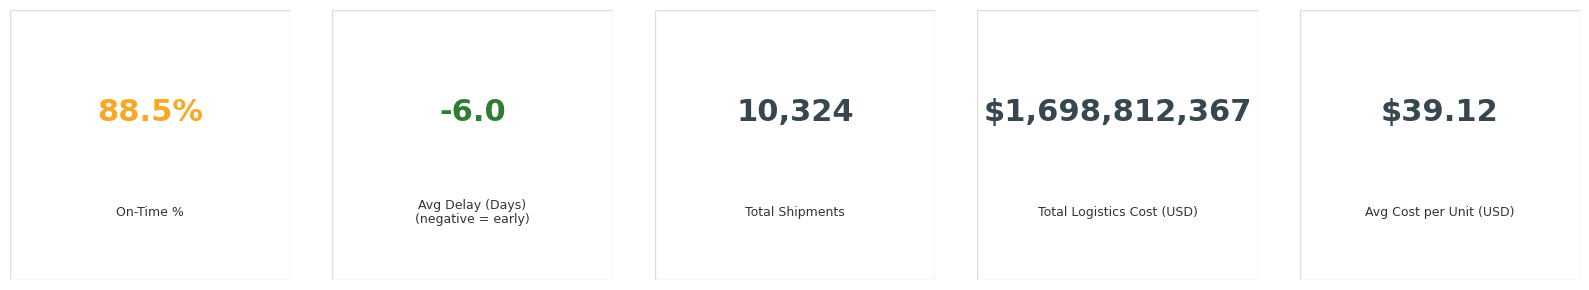

In [22]:
fig, axes = plt.subplots(1, len(tiles), figsize=(16, 3))
fig.patch.set_facecolor("white")

for ax, t in zip(axes, tiles):
    ax.set_axis_off()

    rect = plt.Rectangle(
        (0, 0), 1, 1,
        facecolor="white",
        edgecolor="#dddddd",
        linewidth=1
    )
    ax.add_patch(rect)

    ax.text(
        0.5, 0.62, t["value"],
        ha="center", va="center",
        fontsize=22,
        fontweight="bold",
        color=t["color"]
    )

    ax.text(
        0.5, 0.25, t["label"],
        ha="center", va="center",
        fontsize=9,
        color="#333333"
    )

fig.tight_layout()
fig.savefig("01_kpi.png", dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

### --- 📊 On-Time % by Shipment Mode ---

## Delivery reliability varies significantly by shipment mode.  Shipment mode values marked as ‘N/A’ indicate shipments where transportation mode was not recorded or not applicable. Which makes air shipments the highest known shipments achieving the highest on-time performance.

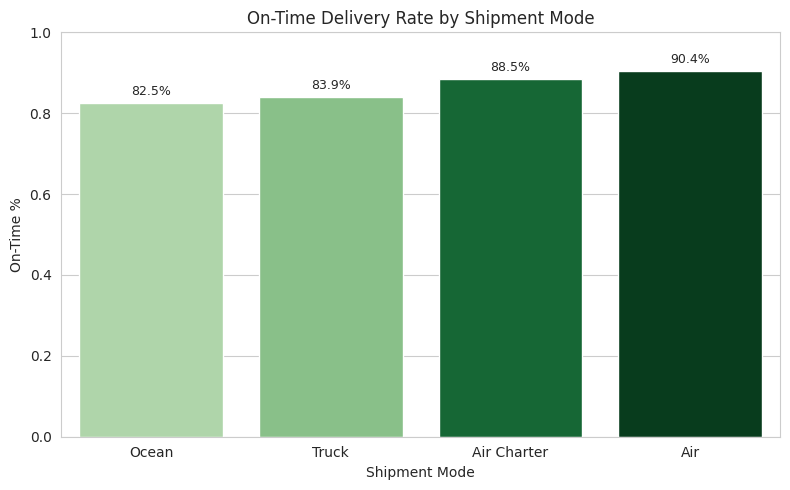

In [23]:
mode = pd.read_csv("analysis_on_time_by_mode.csv").sort_values("on_time_pct", ascending=True)

greens = mpl.colormaps["Greens"]
truncated_greens = mpl.colors.LinearSegmentedColormap.from_list(
    "truncated_greens",
    greens(np.linspace(0.35, 1.0, 256))
)

norm = mpl.colors.Normalize(
    vmin=mode["on_time_pct"].min(),
    vmax=mode["on_time_pct"].max()
)

palette = list(truncated_greens(norm(mode["on_time_pct"])))

fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(
    data=mode,
    x="shipment_mode",
    y="on_time_pct",
    hue="shipment_mode",
    palette=palette,
    legend=False,
    ax=ax
)

ax.set_title("On-Time Delivery Rate by Shipment Mode")
ax.set_xlabel("Shipment Mode")
ax.set_ylabel("On-Time %")
ax.set_ylim(0, 1)

for i, v in enumerate(mode["on_time_pct"].to_numpy()):
    ax.text(i, v + 0.02, f"{v:.1%}", ha="center", fontsize=9)

fig.tight_layout()
fig.savefig("02_on_time_mode.png", dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

### --- 📦Vendor Risk chart ---

## SCMS-managed RDC shipments exhibit lower on-time performance relative to other vendors, indicating potential operational risk.

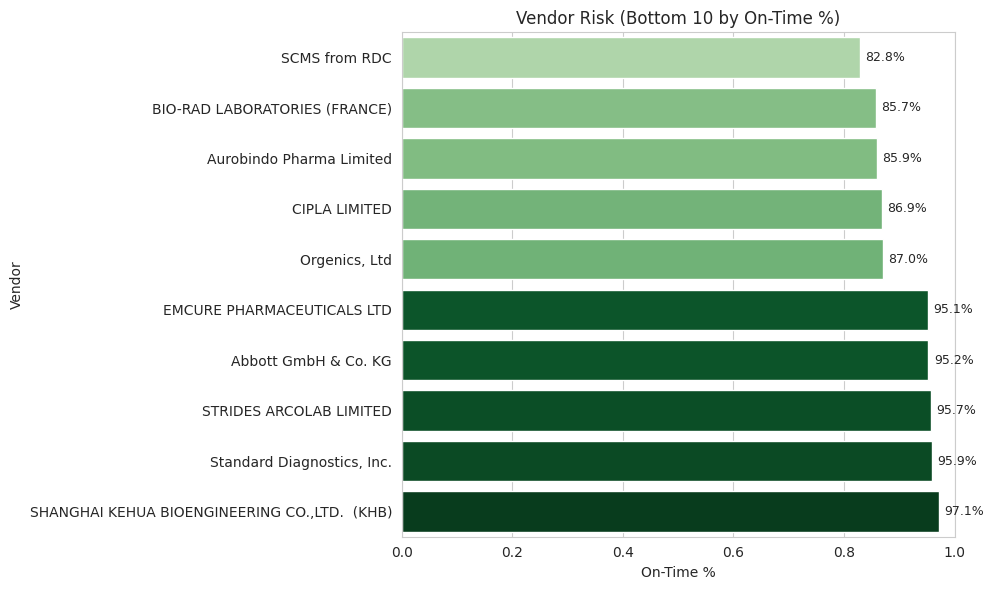

In [24]:
vendor = pd.read_csv("analysis_vendor_risk.csv")

# Bottom 10 vendors by on-time %
vendor_bottom = (
    vendor.sort_values("on_time_pct", ascending=True)
          .head(10)
)

fig, ax = plt.subplots(figsize=(10, 6))

# --- Colormap ---
greens = mpl.colormaps["Greens"]

truncated_greens = mpl.colors.LinearSegmentedColormap.from_list(
    "truncated_greens",
    greens(np.linspace(0.35, 1.0, 256))
)

norm = mpl.colors.Normalize(
    vmin=vendor_bottom["on_time_pct"].min(),
    vmax=vendor_bottom["on_time_pct"].max()
)

palette = list(truncated_greens(norm(vendor_bottom["on_time_pct"])))

# --- Plot ---
sns.barplot(
    data=vendor_bottom,
    x="on_time_pct",
    y="vendor",
    hue="vendor",
    palette=palette,
    legend=False,
    ax=ax
)

ax.set_title("Vendor Risk (Bottom 10 by On-Time %)")
ax.set_xlabel("On-Time %")
ax.set_ylabel("Vendor")
ax.set_xlim(0, 1)

# Label bars
for i, v in enumerate(vendor_bottom["on_time_pct"]):
    ax.text(v + 0.01, i, f"{v:.1%}", va="center", fontsize=9)

fig.tight_layout()
fig.savefig("03_vendor_risk.png", dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)


### --- 📈 Cost vs Reliability ---

## Higher-cost shipment modes are associated with improved reliability, highlighting a tradeoff between service level and logistics spend.

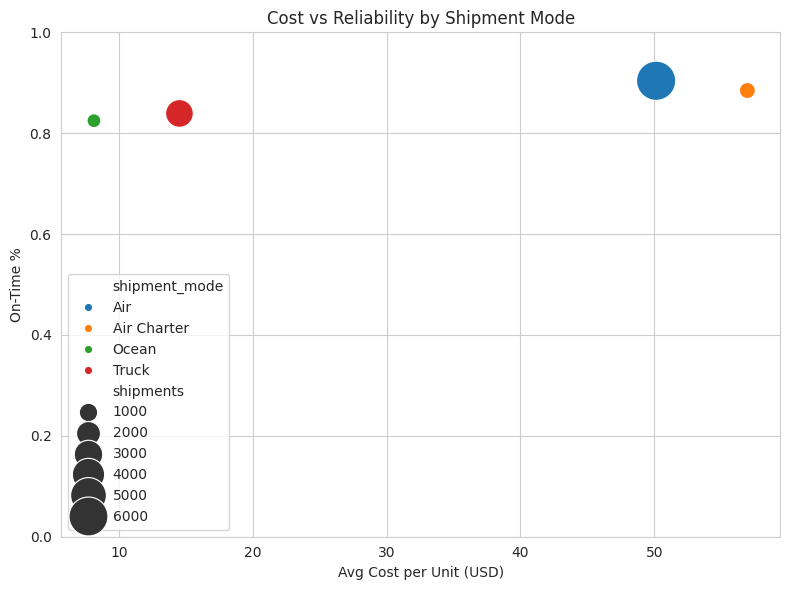

In [25]:
scatter = pd.read_csv("analysis_cost_vs_reliability.csv")

fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    data=scatter,
    x="x_cost_per_unit",
    y="y_on_time_pct",
    size="shipments",
    hue="shipment_mode",
    sizes=(100, 800),
    legend="brief",
    ax=ax
)

ax.set_title("Cost vs Reliability by Shipment Mode")
ax.set_xlabel("Avg Cost per Unit (USD)")
ax.set_ylabel("On-Time %")
ax.set_ylim(0, 1)

fig.tight_layout()
fig.savefig("04_cost_vs_reliability.png", dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)


### --- 🌍 Country Risk (Top 10 volume) ---

## Several high-volume countries also show below-average on-time performance, suggesting priority lanes for intervention.

In [26]:
country_map = (
    df[df["country"].notna()]
      .groupby("country")
      .agg(
          shipments=("shipment_id", "count"),
          on_time_pct=("on_time_flag", "mean"),
          avg_delay_days=("delivery_delay_days", "mean"),
          avg_cost_per_unit=("cost_per_unit", "mean"),
      )
      .reset_index()
)

# Fix known problematic country names
country_map["country"] = country_map["country"].replace({
    "CA te d'Ivoire": "Cote d'Ivoire",
    "CÃ´te d'Ivoire": "Cote d'Ivoire",
})

metric = "on_time_pct"   

fig = px.choropleth(
    country_map,
    locations="country",
    locationmode="country names",   
    color=metric,
    hover_name="country",
    hover_data={
        "shipments": True,
        "on_time_pct": ':.3f',
        "avg_delay_days": ':.2f',
        "avg_cost_per_unit": ':.2f',
    },
    projection="natural earth",
    color_continuous_scale="RdYlGn",
    title=f"Global Supply Chain Map — {metric.replace('_',' ').title()}",
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(title=metric.replace("_"," ").title())
)

fig.show()

fig.write_html("05_country_risk.html")

### --- Convert PNGs to Snapshot files ---

In [27]:
html_path = "05_country_risk.html"
png_path  = "05_country_risk.png"

async def html_to_png(html_path, png_path):
    async with async_playwright() as p:
        browser = await p.chromium.launch()
        page = await browser.new_page(viewport={"width": 1400, "height": 800})
        await page.goto("file://" + os.path.abspath(html_path))
        await page.wait_for_timeout(1500)  # let Plotly render
        await page.screenshot(path=png_path, full_page=True)
        await browser.close()

await html_to_png(html_path, png_path)

print("Saved:", png_path)

files = {
    "kpi": "01_kpi.png",
    "on_time": "02_on_time_mode.png",
    "vendor": "03_vendor_risk.png",
    "cost": "04_cost_vs_reliability.png",
    "country": "05_country_risk.png",
}

OUT_FILE = "dashboard_snapshot.png"
BG = (255, 255, 255)   # white background
PAD = 24               # spacing between charts
TARGET_W = 2000        # final dashboard width

Saved: 05_country_risk.png


### --- Format Images ---

In [28]:
def load_img(path):
    return Image.open(path).convert("RGB")

def resize_to_width(img, w):
    if img.width == w:
        return img
    h = int(img.height * (w / img.width))
    return img.resize((w, h), Image.LANCZOS)

def resize_to_same_height(img1, img2, h):
    def r(img):
        w = int(img.width * (h / img.height))
        return img.resize((w, h), Image.LANCZOS)
    return r(img1), r(img2)

### --- Create Snapshot Dashboard ---

In [29]:
# --- Load & resize KPI full-width ---
kpi = resize_to_width(load_img(files["kpi"]), TARGET_W)

# --- Half width for 2-up rows ---
half_w = (TARGET_W - PAD) // 2

on_time = resize_to_width(load_img(files["on_time"]), half_w)
vendor  = resize_to_width(load_img(files["vendor"]),  half_w)

cost    = resize_to_width(load_img(files["cost"]),    half_w)
country = resize_to_width(load_img(files["country"]), half_w)

# --- Align heights per row ---
row2_h = max(on_time.height, vendor.height)
on_time, vendor = resize_to_same_height(on_time, vendor, row2_h)

row3_h = max(cost.height, country.height)
cost, country = resize_to_same_height(cost, country, row3_h)

# --- Canvas height ---
total_h = kpi.height + PAD + row2_h + PAD + row3_h
canvas = Image.new("RGB", (TARGET_W, total_h), BG)

# --- Paste row 1 ---
y = 0
canvas.paste(kpi, (0, y))
y += kpi.height + PAD

# --- Paste row 2 (On-time | Vendor) ---
canvas.paste(on_time, (0, y))
canvas.paste(vendor, (on_time.width + PAD, y))
y += row2_h + PAD

# --- Paste row 3 (Cost | Country) ---
canvas.paste(cost, (0, y))
canvas.paste(country, (cost.width + PAD, y))

canvas.save(OUT_FILE, quality=95)
print("Saved:", OUT_FILE)

Saved: dashboard_snapshot.png


### ---Dashboard Snapshot ---

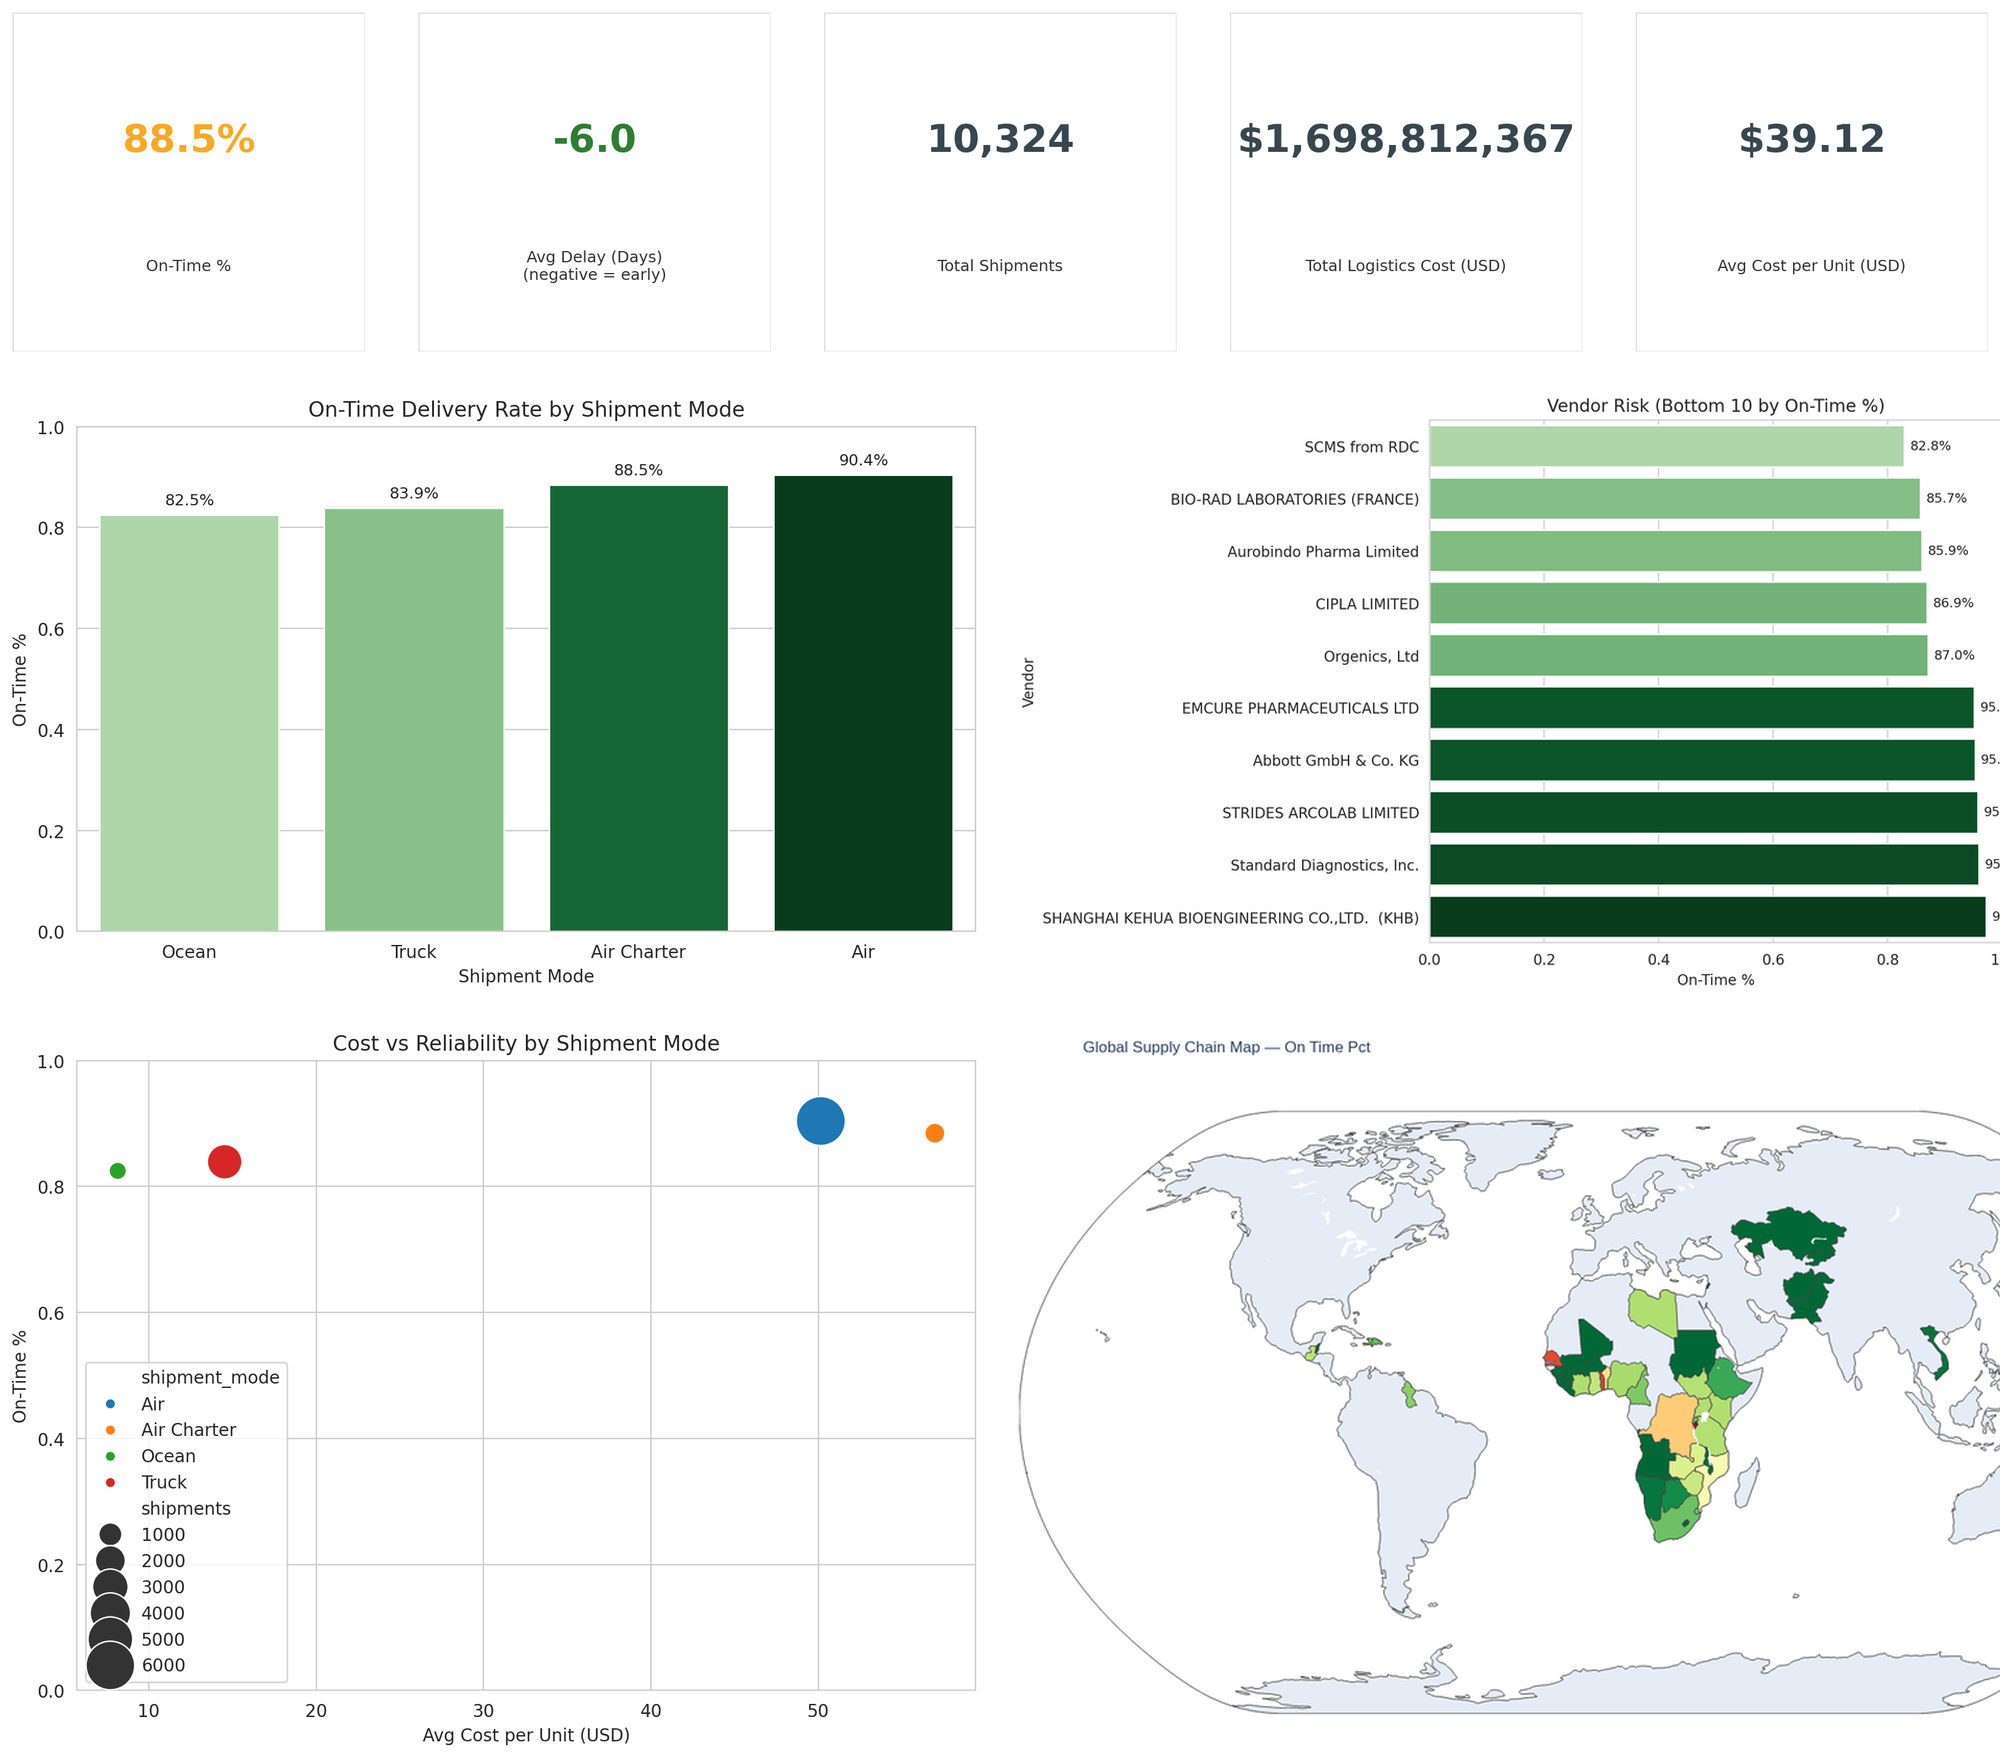

In [30]:
display(IPyImage("dashboard_snapshot.png"))

## Executive Answer
## Excluding N/A shipment mode, the On-Time percentage is 88.1% at a -6.2 Days delayed. While these numbers mean that shipments are expected to arrive about 6 days early, this may harm SLAs and cause distrust amongst customers who may find estimated delivery dates "unreliable".

## The bulk of shipments are through Air with over 6,000 shipments at a 90.4 on time percentage delayed -3.8 days, which is not bad. Although, at an average unit cost of 50 USD. Air shipments are not a very cost effective method. Ocean shipments are the least reliable with 83.5% on-time average 5.9 days delayed, however, at just $8 USD per unit this is the cheapest method. 

## Trucks are the second cheapest shipment mode at $15 USD per unit. Trucks are also the second riskiest mode at 83.9% on-time average at -9.9 days delayed. Since truck shipping is the second most used shipment mode at 2,830 shipments, this is where a third-party logistics provider can intervene.

## The riskiest shipments are centered around the African region and there are only 2 vendors that use truck shipments inside of Africa. By adding 1 or 2 more third-party trucking providers SCMS can increase their on-time average and trade off some of their expensive air shipments with more costly truck shipments.